<a href="https://colab.research.google.com/github/netaamz/DL-Model-for-Automated-Detection-of-Meniscus-Tears-in-Knee-MRI-Images/blob/main/data_preprocess17d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data and exctract images

**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):**
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports.
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* validation set: consists of 120 MRI images from coronal, sagittal and transverse planes


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd

In [ ]:
train_path = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/train'
valid_path = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid'
datasets = {'train': train_path, 'valid': valid_path}
planes = ['coronal', 'sagittal', 'axial']
diagnosis = ['meniscus']


In [ ]:
def get_data(dataset_type, plane, diagnosis):
    '''this function gets the data from the original dataset'''
    if dataset_type == 'train':
        go = train_path
    else:
        go = valid_path
    plane_dir = f'{go}/{plane}'
    data = os.listdir(plane_dir)

    label_path = f'/content/drive/My Drive/miniscus data set/MRNet-v1.0/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])

    return(data, plane_dir, label_data)

**Get meniscus dataset**

In [ ]:
# training data
train_coronal_data, train_coronal_dir, train_men_label = get_data('train', 'coronal', 'meniscus')
train_axial_data, train_axial_dir, train_men_label = get_data('train', 'axial', 'meniscus')
train_sagittal_data, train_sagittal_dir, train_men_label = get_data('train', 'sagittal', 'meniscus')

In [ ]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_men_label = get_data('valid','coronal','meniscus')
valid_axial_data, valid_axial_dir, valid_men_label = get_data('valid','axial','meniscus')
valid_sagittal_data, valid_sagittal_dir, valid_men_label = get_data('valid','sagittal','meniscus')

The dataset contains *s* x 256 x 256 images. Since middle images are the
most useful, only 3 middle slides in the series are retained.


## Pre processing images


applying white top hat filter as suggested at [Automatic knee meniscus tear detection and orientation classification with Mask-RCNN](https://www.sciencedirect.com/science/article/pii/S2211568419300580?via%3Dihub)

Before:
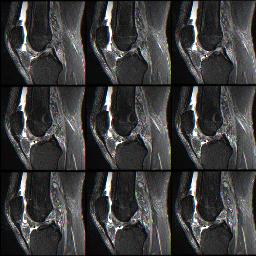

After: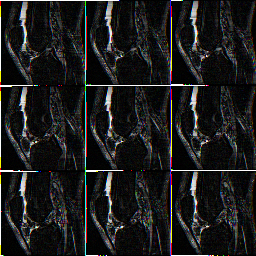

In [ ]:
import cv2
import numpy as np

def white_top_hat_filter(image, kernel_size=(10, 10)):
    # Create a structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)

    # Apply white top hat filter
    filtered = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)

    return filtered

In [ ]:
import numpy as np
def get_middle_slices(scan, num_slices=17):
    depth = scan.shape[0]  # The depth is the first dimension of the scan

    # Calculate the middle index
    middle = depth // 2

    # Calculate the starting and ending indices for the 17 middle slices
    start = max(0, middle - num_slices // 2)
    end = min(depth, start + num_slices)  # Ensure you don't go beyond the total depth

    # Slice the scan to get the middle 17 slices
    middle_slices = scan[start:end, :, :]

    return middle_slices

In [ ]:
import os
import numpy as np

def image_extraction(data, path, new_path, selem_radius=10, num_slices=17):
    '''this function extracts middle slide of each scan'''
    extract=[]
    new_data=[]
    for i in range(len(data)):
        file_path = os.path.join(path,data[i])
        # Check if the file is a valid NumPy file before loading
        if file_path.endswith('.npy'):
            img = np.load(file_path)
            sliced_image=get_middle_slices(img, num_slices)
            filtered_mri = np.zeros_like(sliced_image)
            for i in range(num_slices):
              filtered_mri[i] = white_top_hat_filter(sliced_image[i])
            img = filtered_mri
            #img = img.reshape(256, 256, num_slices)  # Reshape to ( 256, 256, 1)
            extract.extend(img)
            new_data.append(np.array(extract))
            extract.clear()
        else:
            print(f"Skipping non-NumPy file: {file_path}")
    # Create the directory if it doesn't exist
    os.makedirs(new_path, exist_ok=True)
    # Add a filename to the new_path before saving
    np.save(os.path.join(new_path, 'extracted_images.npy'), np.array(new_data)) # Add a filename to the path

**Image extraction for training data**

In [ ]:
# image extraction for coronal plane
new_path = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform17d/coronal/'
image_extraction(train_coronal_data, train_coronal_dir, new_path)

Skipping non-NumPy file: /content/drive/My Drive/miniscus data set/MRNet-v1.0/train/coronal/.DS_Store


In [ ]:
# image extraction for sagittal plane
new_path = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform17d/sagittal/'
image_extraction(train_sagittal_data, train_sagittal_dir, new_path)

Skipping non-NumPy file: /content/drive/My Drive/miniscus data set/MRNet-v1.0/train/sagittal/.DS_Store


In [ ]:
# image extraction for axial plane
new_path = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform17d/axial/'
image_extraction(train_axial_data, train_axial_dir, new_path)

Skipping non-NumPy file: /content/drive/My Drive/miniscus data set/MRNet-v1.0/train/axial/.DS_Store


In [ ]:
image = np.load('/content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform17d/coronal/extracted_images.npy')

**Image extraction for validation data**

In [ ]:
# image extraction for coronal plane
new_path = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform17d/coronal'
image_extraction(valid_coronal_data, valid_coronal_dir, new_path)

In [ ]:
# image extraction for sagittal plane
new_path = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform17d/sagittal'
image_extraction(valid_sagittal_data, valid_sagittal_dir, new_path)

In [ ]:
# image extraction for axial plane
new_path = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform17d/axial'
image_extraction(valid_axial_data, valid_axial_dir, new_path)

## **data generation for meniscus**

In [ ]:
def data_gen(dataset_type, plane, diagnosis):
    '''this function gets the data from the extracted datset'''
    # for eg, (train, sagittal, mensicus)
    if dataset_type == 'train':
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform17d' # if we want without filter then:  /content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform
    else:
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform17d' # if we want without filter then: /content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform

    plane_dir = f'{go}/{plane}.npy'

    data = np.load(plane_dir)
    label_path = f'/content/drive/My Drive/miniscus data set/MRNet-v1.0/{dataset_type}-{diagnosis}.csv'
#     label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])

    return(data, label_data)


In [ ]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal/extracted_images', 'meniscus')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def display_scan(scan):
    num_slices = scan.shape[0]

    # Calculate grid size (rows and columns) for displaying the slices
    num_cols = 5  # You can change this to arrange the grid differently
    num_rows = (num_slices + num_cols - 1) // num_cols  # Calculate number of rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i in range(num_rows * num_cols):
        if i < num_slices:
            row = i // num_cols
            col = i % num_cols
            # Display each slice in the grid
            axes[row, col].imshow(scan[i], cmap='gray')
            axes[row, col].axis('off')  # Turn off axis labels
        else:
            # Hide any empty subplot
            axes[i // num_cols, i % num_cols].axis('off')

    plt.show()

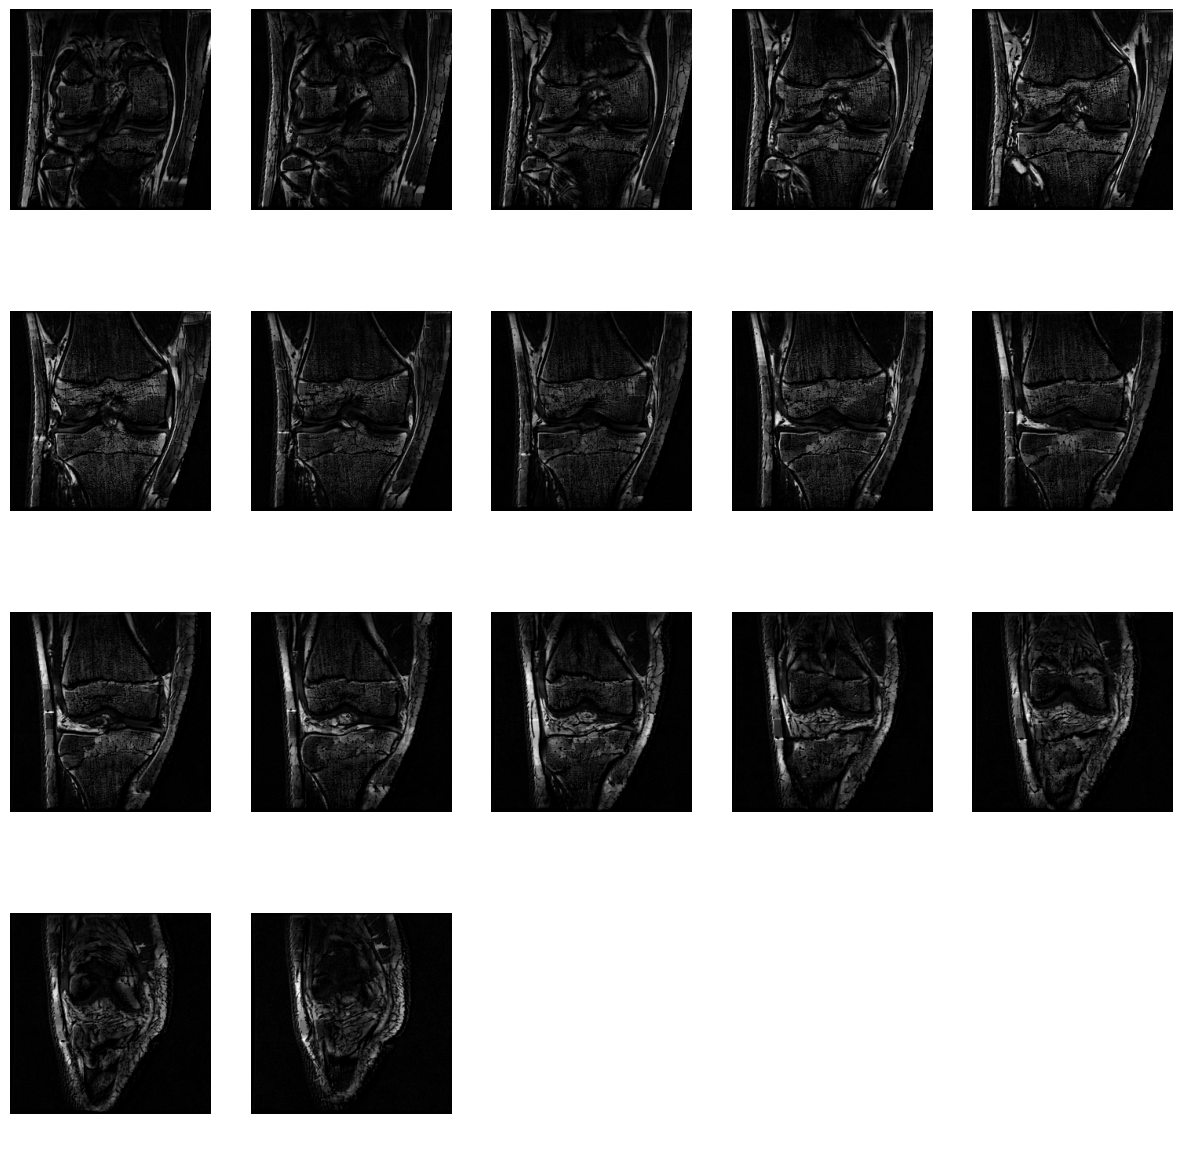

In [ ]:
display_scan(coronal_mensicus[50])

In [ ]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal/extracted_images', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial/extracted_images', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal/extracted_images', 'meniscus')
print(sagittal_mensicus.shape)
# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal/extracted_images', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial/extracted_images', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal/extracted_images', 'meniscus')

(120, 17, 256, 256)
